In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

scaler = StandardScaler()

In [2]:
train_df = pd.read_csv(r'C:\Users\Customer Churn Train.csv')
test_df = pd.read_csv(r'C:\Users\Customer Churn Test.csv')
train_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
test_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [4]:
# cleaning numeric columns
def clean_numeric_columns(df):
    for col in df.select_dtypes(include=[np.number]).columns:
       
        if (df[col] % 1 == 0).all():
            df[col] = df[col].astype('Int64') 
    return df

# Apply to both 
train_df = clean_numeric_columns(train_df)
test_df = clean_numeric_columns(test_df)

print("Initial shapes of both train and test")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")

Initial shapes of both train and test
Train: (440833, 12)
Test: (64374, 12)


In [5]:
int_cols = ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls',
            'Payment Delay', 'Last Interaction', 'Total Spend', 'Churn']

# Convert columns to Integer 
def convert_to_int(df):
    for col in int_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

train_df = convert_to_int(train_df)
test_df = convert_to_int(test_df)

print(" Data Types Check - Training")
print(train_df.dtypes)
print(" Data Types Check - Testing")
print(test_df.dtypes)

 Data Types Check - Training
CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object
 Data Types Check - Testing
CustomerID            Int32
Age                    Int8
Gender               object
Tenure                 Int8
Usage Frequency        Int8
Support Calls          Int8
Payment Delay          Int8
Subscription Type    object
Contract Length      object
Total Spend           Int16
Last Interaction       Int8
Churn                  Int8
dtype: object


In [6]:
#  since all Testing are in Int8, we need to Convert all numerical columns in testing data to float64
float_columns = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 
                 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']

for col in float_columns:
    test_df[col] = test_df[col].astype('float64')

In [7]:
## DROP CUSTTOMER ID
train_df = train_df.drop('CustomerID', axis=1)
test_df = test_df.drop('CustomerID', axis=1)

In [8]:
train_df.head()
test_df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22.0,Female,25.0,14.0,4.0,27.0,Basic,Monthly,598.0,9.0,1.0
1,41.0,Female,28.0,28.0,7.0,13.0,Standard,Monthly,584.0,20.0,0.0
2,47.0,Male,27.0,10.0,2.0,29.0,Premium,Annual,757.0,21.0,0.0
3,35.0,Male,9.0,12.0,5.0,17.0,Premium,Quarterly,232.0,18.0,0.0
4,53.0,Female,58.0,24.0,9.0,2.0,Standard,Annual,533.0,18.0,0.0


In [9]:
train_df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [10]:
print("Training data types after cleanup:")
print(train_df.dtypes)
print("\nTesting data types after cleanup:")
print(test_df.dtypes)

Training data types after cleanup:
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

Testing data types after cleanup:
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object


In [11]:
print("\nMissing values check:")
print("Training:", train_df.isnull().sum().sum())
print("Testing:", test_df.isnull().sum().sum())


Missing values check:
Training: 11
Testing: 0


In [12]:
train_df = train_df.dropna()

print("Missing values post dropping:\n", train_df.isna().sum())
print("\n Shape of NOW dataset:", train_df.shape)

Missing values post dropping:
 Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

 Shape of NOW dataset: (440832, 11)


In [13]:
for col in train_df.columns:
    print(f"{col}: {train_df[col].nunique()} unique values")

Age: 48 unique values
Gender: 2 unique values
Tenure: 60 unique values
Usage Frequency: 30 unique values
Support Calls: 11 unique values
Payment Delay: 31 unique values
Subscription Type: 3 unique values
Contract Length: 3 unique values
Total Spend: 68363 unique values
Last Interaction: 30 unique values
Churn: 2 unique values


In [14]:
num_cols = train_df.select_dtypes(include=['int64', 'float64', 'int32', 'int8']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

print("Numeric columns:\n", list(num_cols))
print("\nCategorical columns:\n", list(cat_cols))


print("\nSummary Statistics (Numeric Ones):\n")
display(train_df[num_cols].describe())


print("\nSummary Statistics (Categorical):\n")
display(train_df[cat_cols].describe())

Numeric columns:
 ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']

Categorical columns:
 ['Gender', 'Subscription Type', 'Contract Length']

Summary Statistics (Numeric Ones):



,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000



Summary Statistics (Categorical):



,Gender,Subscription Type,Contract Length
count,440832,440832,440832
unique,2,3,3
top,Male,Standard,Annual
freq,250252,149128,177198


 DISTRIBUTION ANALYSIS

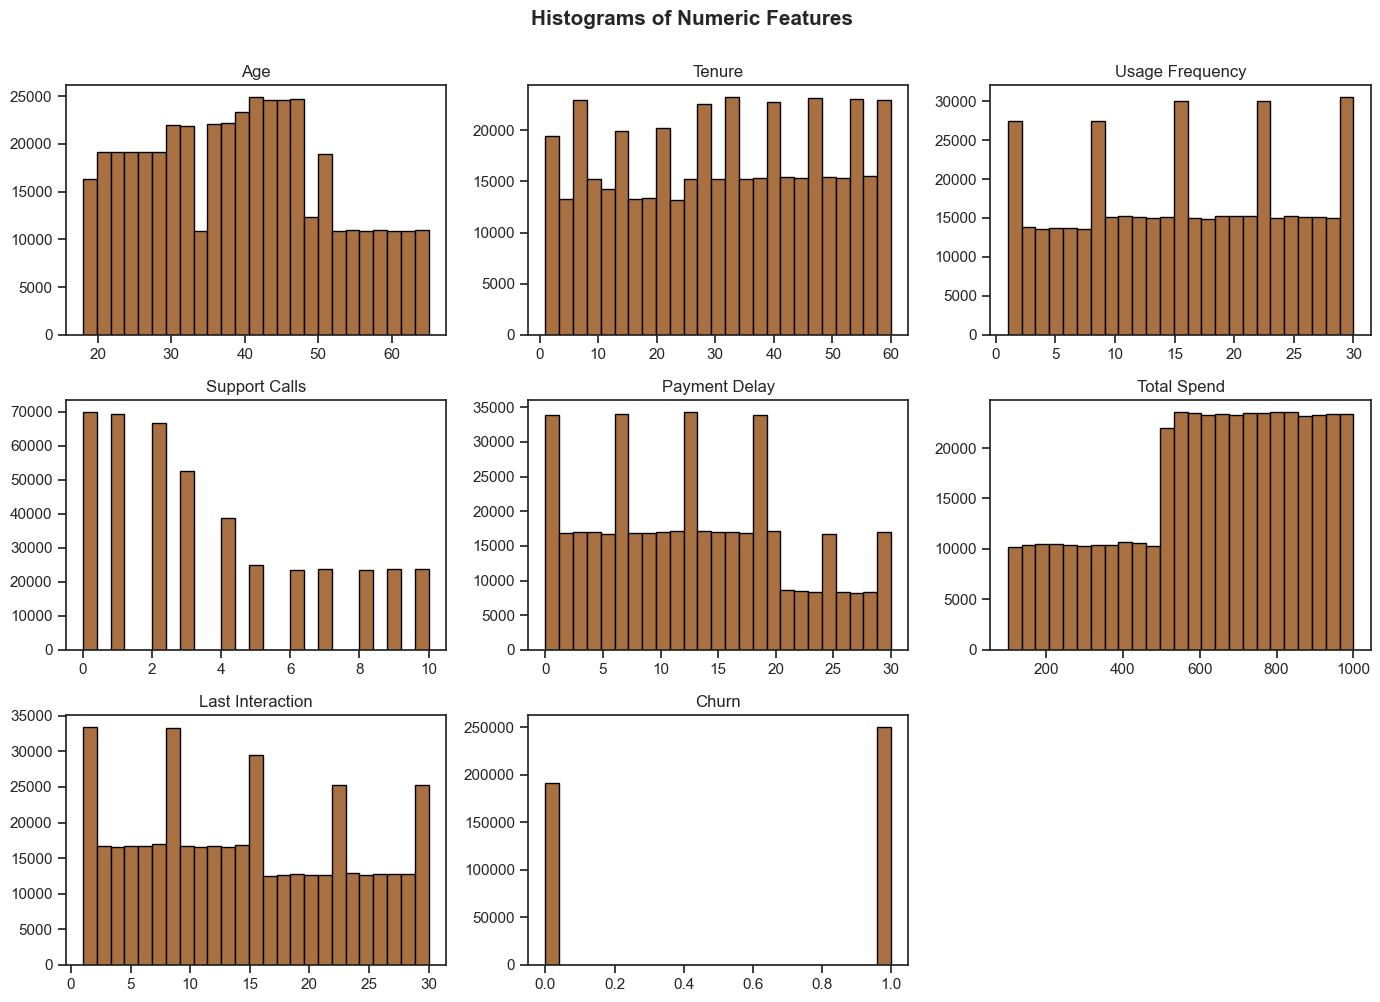

In [16]:
sns.set(style="ticks")

# Histograms
num_cols = train_df.select_dtypes(include=['int64', 'float64', 'int32', 'int8']).columns

train_df[num_cols].hist(
    figsize=(14, 10),
    bins=25,
    color="#a97142",       
    edgecolor="black",
    grid=False
)
plt.suptitle("Histograms of Numeric Features", fontsize=15, y=1, fontweight='bold')
plt.tight_layout()
plt.show()

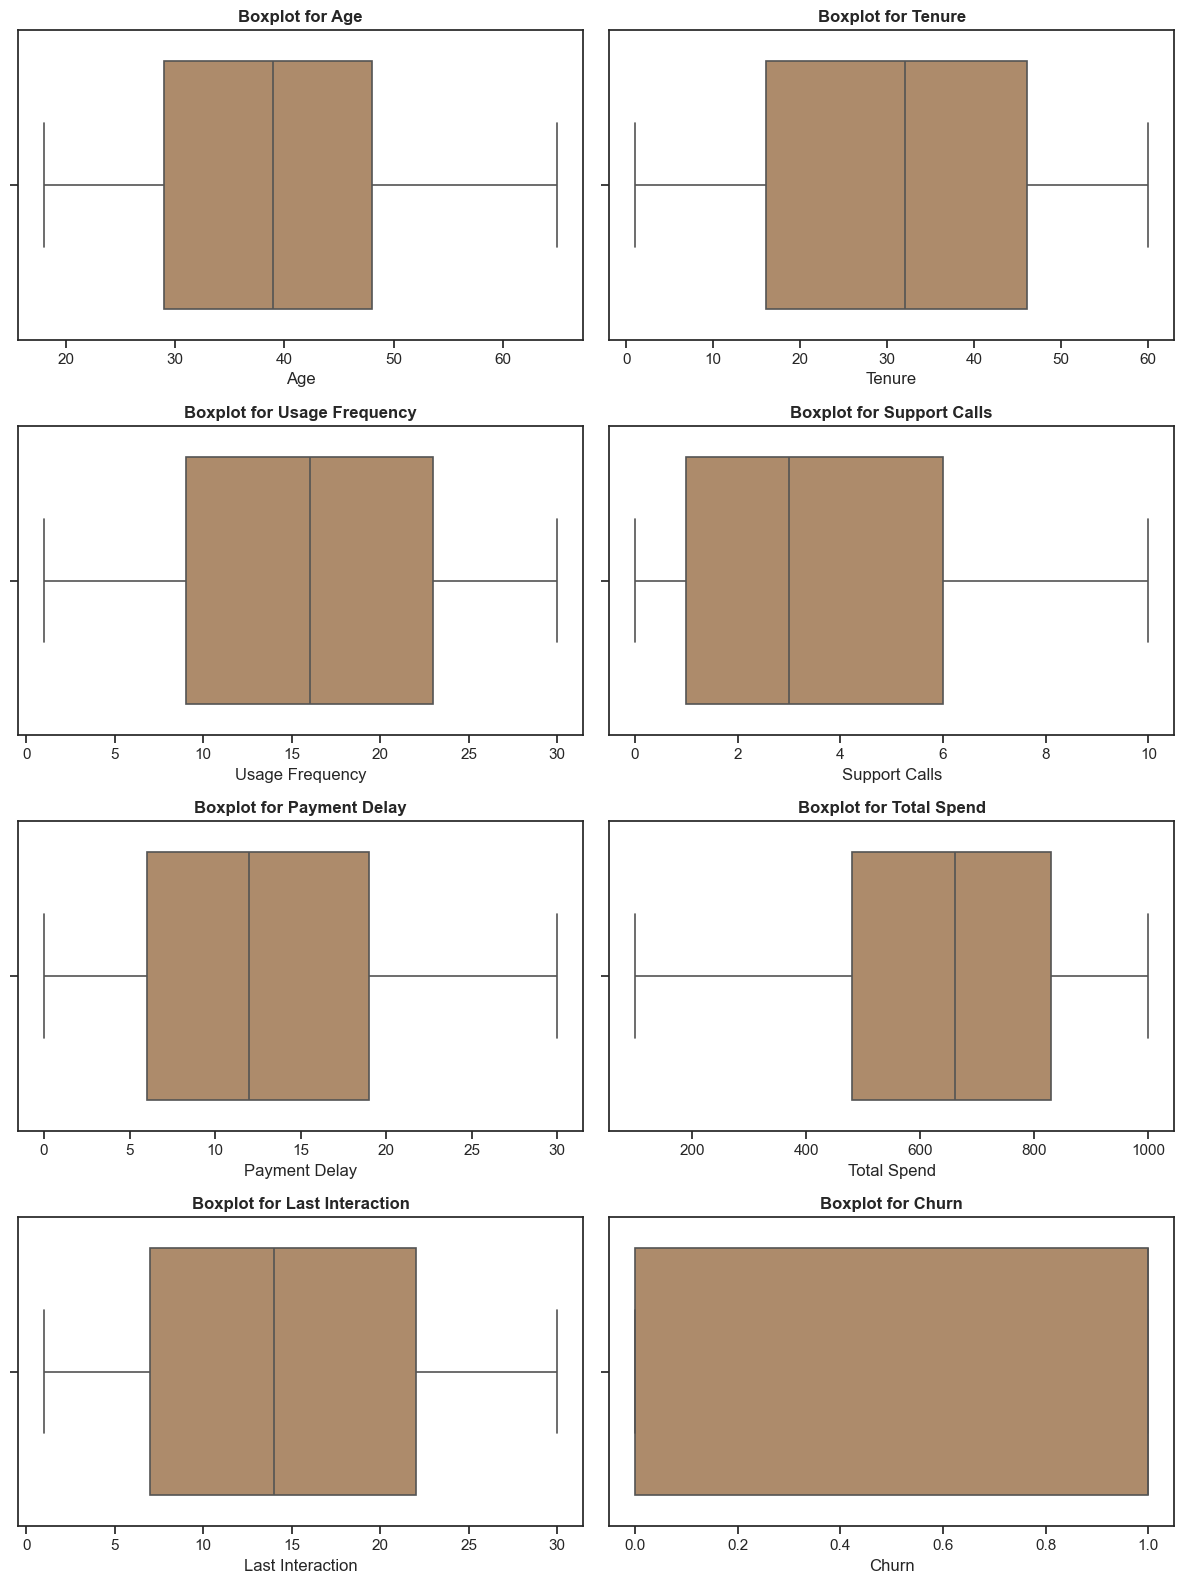

In [17]:
# Boxplots
cols = list(num_cols)
num_features = len(cols)

rows = int(np.ceil(num_features / 2))
fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(
        x=train_df[col],
        ax=axes[i],
        color="#b88a60",       
        fliersize=3,
        linewidth=1.2
    )
    axes[i].set_title(f"Boxplot for {col}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_7284\1585262821.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x=col,
C:\Users\USER\AppData\Local\Temp\ipykernel_7284\1585262821.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x=col,
C:\Users\USER\AppData\Local\Temp\ipykernel_7284\1585262821.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x=col,


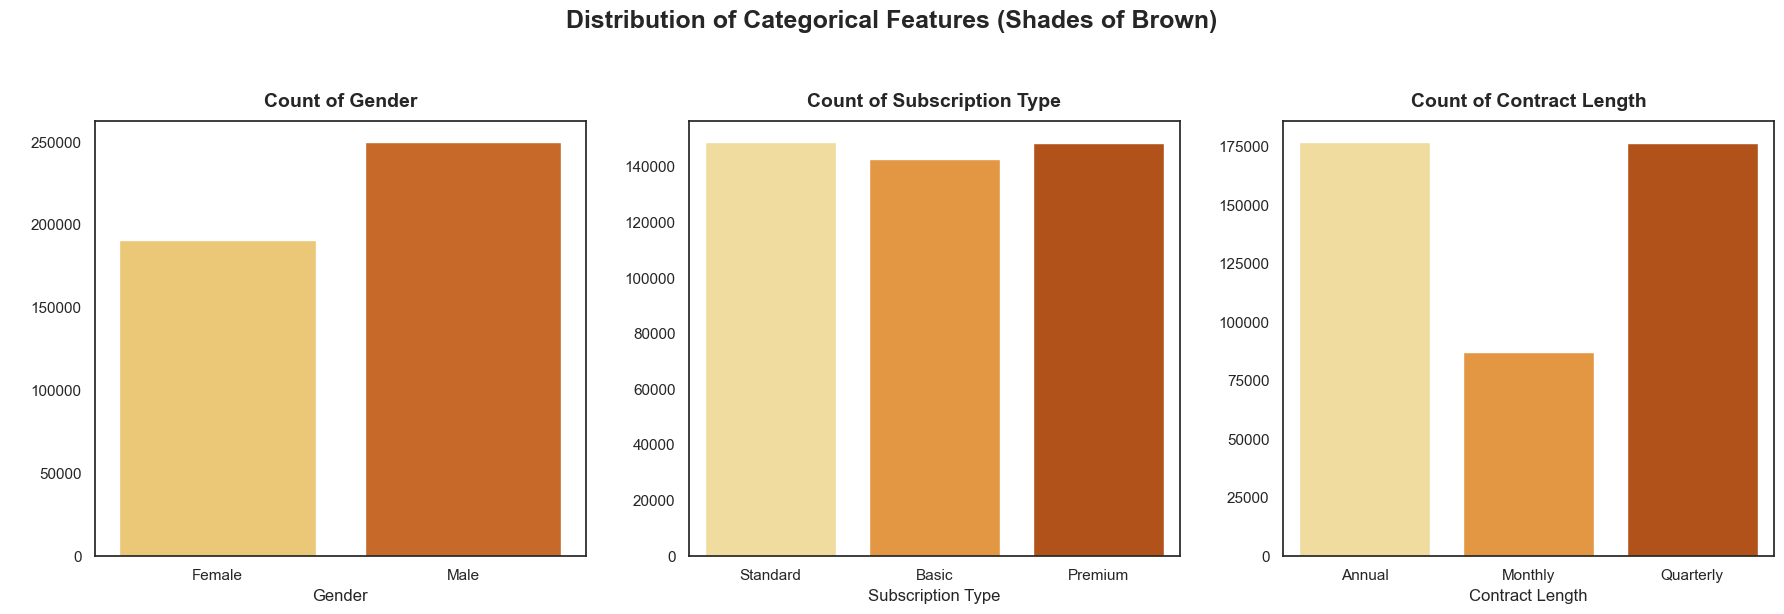

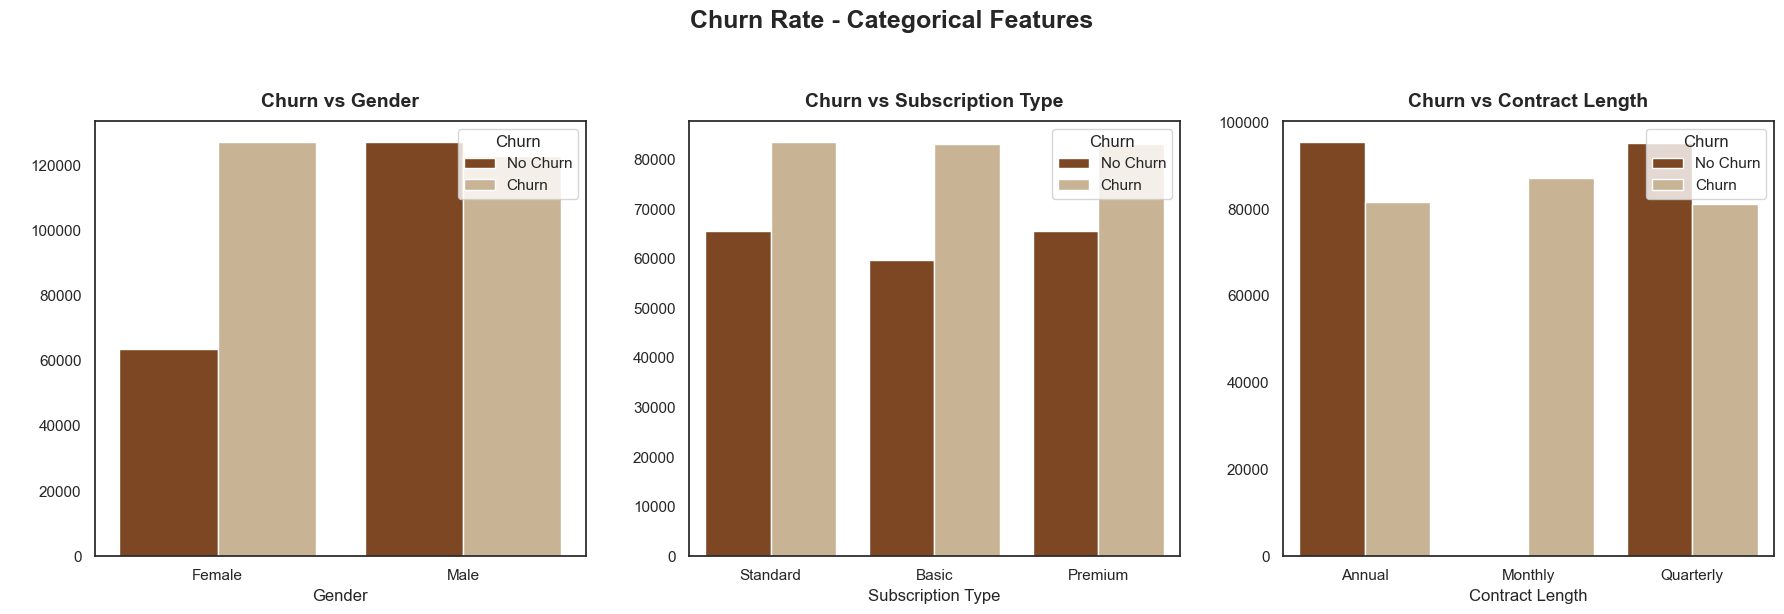

In [18]:
sns.set_style("white")
CHURN_BROWN_PALETTE = ['#8B4513', '#D2B48C'] 

# Categorical Features 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(cat_cols):
    sns.countplot(data=train_df, x=col, 
                  palette="YlOrBr", 
                  ax=axes[i])
    axes[i].set_title(f"Count of {col}", fontsize=14, fontweight='bold', pad=10)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel(" ", fontsize=12)

plt.suptitle("Distribution of Categorical Features (Shades of Brown)", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show() 

#  Churn Rates

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(cat_cols):
    sns.countplot(data=train_df, x=col, hue='Churn', 
                  palette=CHURN_BROWN_PALETTE, 
                  ax=axes[i])
    axes[i].set_title(f"Churn vs {col}", fontsize=14, fontweight='bold', pad=10)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel(" ", fontsize=12)
    axes[i].legend(title='Churn', loc='upper right', labels=['No Churn', 'Churn'])
    
plt.suptitle("Churn Rate - Categorical Features", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

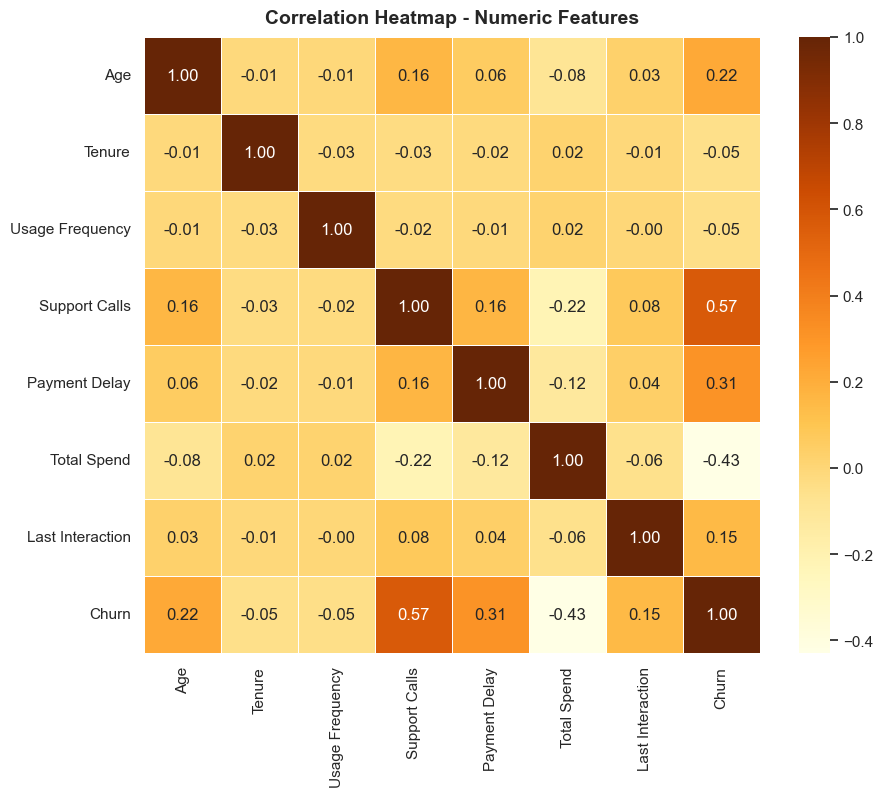

In [19]:
sns.set(style="white")
num_cols = train_df.select_dtypes(include=['int64', 'float64', 'int32', 'int8']).columns
corr = train_df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="YlOrBr",   # warm brownish color palette
    linewidths=0.5,
    square=True
)
plt.title("Correlation Heatmap - Numeric Features", fontsize=14, fontweight='bold', pad=10)
plt.show()

feature engineering

In [21]:
# Separate features and target BEFORE any feature engineering
X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']
X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']

In [22]:
#new features 
X_train['Support_Calls_per_Month'] = X_train['Support Calls'] / (X_train['Tenure'] + 1)
X_test['Support_Calls_per_Month'] = X_test['Support Calls'] / (X_test['Tenure'] + 1)

X_train['Spend_per_Use'] = X_train['Total Spend'] / (X_train['Usage Frequency'] + 1)
X_test['Spend_per_Use'] = X_test['Total Spend'] / (X_test['Usage Frequency'] + 1)

In [23]:
train_median = X_train['Total Spend'].median()
X_train['High_Spender'] = (X_train['Total Spend'] > train_median).astype(int)
X_test['High_Spender'] = (X_test['Total Spend'] > train_median).astype(int)

 Initialize on training data

In [32]:
from sklearn.preprocessing import OneHotEncoder

# Define the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


# Fit on training only
encoder.fit(X_train[['Gender', 'Subscription Type', 'Contract Length']])

# Transform both
train_encoded = encoder.transform(X_train[['Gender', 'Subscription Type', 'Contract Length']])
test_encoded = encoder.transform(X_test[['Gender', 'Subscription Type', 'Contract Length']])

# Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out())
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out())

In [33]:
# Fit on training only
scaler.fit(X_train[['Age', 'Total Spend', 'Usage Frequency']])

# Transform both
X_train_scaled = scaler.transform(X_train[['Age', 'Total Spend', 'Usage Frequency']])
X_test_scaled = scaler.transform(X_test[['Age', 'Total Spend', 'Usage Frequency']])

In [34]:
def create_safe_features(X_train, X_test):
    """
    Create features without data leakage
    Returns: Transformed X_train and X_test
    """
    # Create copies 
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    
    # 1. Simple ratio features. 
    features_to_create = [
        ('Support_Calls_per_Month', 'Support Calls', 'Tenure'),
        ('Spend_per_Use', 'Total Spend', 'Usage Frequency'),
        ('Payment_Delay_Ratio', 'Payment Delay', 'Tenure'),
        ('Value_Interaction', 'Total Spend', 'Last Interaction')
    ]
    
    for new_name, num_col, den_col in features_to_create:
        X_train_fe[new_name] = X_train_fe[num_col] / (X_train_fe[den_col] + 1)
        X_test_fe[new_name] = X_test_fe[num_col] / (X_test_fe[den_col] + 1)
    
    # 2. Statistical features
    thresholds = {
        'High_Support': X_train_fe['Support Calls'].quantile(0.75),
        'Late_Payer': 14,  # Business rule
        'Inactive': X_train_fe['Last Interaction'].quantile(0.75),
        'Low_Usage': X_train_fe['Usage Frequency'].quantile(0.25)
    }
    
    # Applying the sme threshold
    X_train_fe['High_Support_User'] = (X_train_fe['Support Calls'] > thresholds['High_Support']).astype(int)
    X_test_fe['High_Support_User'] = (X_test_fe['Support Calls'] > thresholds['High_Support']).astype(int)
    
    X_train_fe['Late_Payer'] = (X_train_fe['Payment Delay'] > thresholds['Late_Payer']).astype(int)
    X_test_fe['Late_Payer'] = (X_test_fe['Payment Delay'] > thresholds['Late_Payer']).astype(int)
    
    # 3. Customer segmentation
    spend_q1 = X_train_fe['Total Spend'].quantile(0.25)
    spend_q3 = X_train_fe['Total Spend'].quantile(0.75)
    
    def segment_spending(x, low=spend_q1, high=spend_q3):
        if x < low:
            return 'Low'
        elif x > high:
            return 'High'
        else:
            return 'Medium'
    
    X_train_fe['Spending_Segment'] = X_train_fe['Total Spend'].apply(segment_spending)
    X_test_fe['Spending_Segment'] = X_test_fe['Total Spend'].apply(segment_spending)
    
    # 4. Interaction features
    X_train_fe['Support_Spend_Interaction'] = X_train_fe['Support Calls'] * X_train_fe['Total Spend']
    X_test_fe['Support_Spend_Interaction'] = X_test_fe['Support Calls'] * X_test_fe['Total Spend']
    
    X_train_fe['Usage_Payment_Interaction'] = X_train_fe['Usage Frequency'] / (X_train_fe['Payment Delay'] + 1)
    X_test_fe['Usage_Payment_Interaction'] = X_test_fe['Usage Frequency'] / (X_test_fe['Payment Delay'] + 1)
    
    return X_train_fe, X_test_fe

# Apply safely
X_train_fe, X_test_fe = create_safe_features(X_train, X_test)

TESTING FOR DATA LEAKAGE

In [36]:
def check_leakage(X_train, X_test):
    """Quick checks for data leakage signs"""
    
    # Check 1: FEATURE RANGES SHOULD NOT BE SO DIFFERENT
    print("Feature range comparison:")
    for col in ['Total Spend', 'Support Calls', 'Payment Delay']:
        if col in X_train.columns:
            train_range = X_train[col].max() - X_train[col].min()
            test_range = X_test[col].max() - X_test[col].min()
            diff_ratio = test_range / train_range
            print(f"{col}: Train range={train_range:.2f}, Test range={test_range:.2f}, Ratio={diff_ratio:.2f}")
    
    # Check 2: Missing value
    print("\nMissing value patterns:")
    train_missing = X_train.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()
    print(f"Train missing: {train_missing}, Test missing: {test_missing}")
    
    # Check 3: Feature correlations with target (train only!)

    
    return "ALL GOOD!!!" if test_range > 0 else "Potential leakage"

# Run checks
check_leakage(X_train_fe, X_test_fe)

Feature range comparison:
Total Spend: Train range=900.00, Test range=900.00, Ratio=1.00
Support Calls: Train range=10.00, Test range=10.00, Ratio=1.00
Payment Delay: Train range=30.00, Test range=30.00, Ratio=1.00

Missing value patterns:
Train missing: 0, Test missing: 0


'ALL GOOD!!!'

In [37]:
X_train_fe.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Support_Calls_per_Month,Spend_per_Use,High_Spender,Payment_Delay_Ratio,Value_Interaction,High_Support_User,Late_Payer,Spending_Segment,Support_Spend_Interaction,Usage_Payment_Interaction
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,0.125000,62.133333,1,0.450000,51.777778,0,1,High,4660.0,0.736842
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,0.200000,278.500000,0,0.160000,79.571429,1,0,Medium,5570.0,0.111111
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,0.400000,37.000000,0,1.200000,46.250000,0,1,Low,1110.0,0.210526
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,0.179487,18.000000,0,0.179487,13.200000,1,0,Low,2772.0,2.625000
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,0.151515,29.380952,0,0.242424,29.380952,0,0,Medium,3085.0,2.222222


In [38]:
X_test_fe.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Support_Calls_per_Month,Spend_per_Use,High_Spender,Payment_Delay_Ratio,Value_Interaction,High_Support_User,Late_Payer,Spending_Segment,Support_Spend_Interaction,Usage_Payment_Interaction
0,22.0,Female,25.0,14.0,4.0,27.0,Basic,Monthly,598.0,9.0,0.153846,39.866667,0,1.038462,59.800000,0,1,Medium,2392.0,0.500000
1,41.0,Female,28.0,28.0,7.0,13.0,Standard,Monthly,584.0,20.0,0.241379,20.137931,0,0.448276,27.809524,1,0,Medium,4088.0,2.000000
2,47.0,Male,27.0,10.0,2.0,29.0,Premium,Annual,757.0,21.0,0.071429,68.818182,1,1.035714,34.409091,0,1,Medium,1514.0,0.333333
3,35.0,Male,9.0,12.0,5.0,17.0,Premium,Quarterly,232.0,18.0,0.500000,17.846154,0,1.700000,12.210526,0,1,Low,1160.0,0.666667
4,53.0,Female,58.0,24.0,9.0,2.0,Standard,Annual,533.0,18.0,0.152542,21.320000,0,0.033898,28.052632,1,0,Medium,4797.0,8.000000


In [39]:


def analyze_datasets(X_train_fe, X_test_fe, y_train, y_test):
    """
    Comprehensive analysis of engineered datasets
    """
    print("=" * 80)
    print("DATASET ANALYSIS AFTER FEATURE ENGINEERING")
    print("=" * 80)
    
    # Combine features with target for some analyses
    train_combined = pd.concat([X_train_fe, y_train], axis=1)
    test_combined = pd.concat([X_test_fe, y_test], axis=1)
    
    # =========================================================================
    # 1. BASIC DATASET INFORMATION
    # =========================================================================
    print("\n1. BASIC DATASET INFORMATION")
    print("-" * 40)
    
    print(f"Training set shape: {X_train_fe.shape}")
    print(f"Testing set shape: {X_test_fe.shape}")
    
    print(f"\nTraining samples: {len(X_train_fe)}")
    print(f"Testing samples: {len(X_test_fe)}")
    print(f"Total samples: {len(X_train_fe) + len(X_test_fe)}")
    print(f"Train/Test ratio: {len(X_train_fe)/len(X_test_fe):.2f}")
    
    # =========================================================================
    # 2. DATA TYPES AND MISSING VALUES
    # =========================================================================
    print("\n2. DATA TYPES AND MISSING VALUES")
    print("-" * 40)
    
    print("Training data types:")
    print(X_train_fe.dtypes.value_counts())
    
    print("\nTesting data types:")
    print(X_test_fe.dtypes.value_counts())
    
    print("\nMissing values:")
    print(f"Training: {X_train_fe.isnull().sum().sum()} total missing values")
    print(f"Testing: {X_test_fe.isnull().sum().sum()} total missing values")
    
    # Check for infinite values
    train_inf = np.isinf(X_train_fe.select_dtypes(include=[np.number])).sum().sum()
    test_inf = np.isinf(X_test_fe.select_dtypes(include=[np.number])).sum().sum()
    print(f"\nInfinite values:")
    print(f"Training: {train_inf}")
    print(f"Testing: {test_inf}")
    
    # =========================================================================
    # 3. TARGET DISTRIBUTION
    # =========================================================================
    print("\n3. TARGET DISTRIBUTION")
    print("-" * 40)
    
    train_churn_rate = y_train.mean()
    test_churn_rate = y_test.mean()
    
    print(f"Training Churn Rate: {train_churn_rate:.2%}")
    print(f"Testing Churn Rate: {test_churn_rate:.2%}")
    print(f"Difference: {abs(train_churn_rate - test_churn_rate):.4f}")
    
    # =========================================================================
    # 4. FEATURE SUMMARY STATISTICS
    # =========================================================================
    print("\n4. FEATURE SUMMARY STATISTICS")
    print("-" * 40)
    
    # Separate original and engineered features
    original_features = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 
                        'Support Calls', 'Payment Delay', 'Subscription Type',
                        'Contract Length', 'Total Spend', 'Last Interaction']
    
    # Get engineered features (features not in original list)
    engineered_features = [col for col in X_train_fe.columns if col not in original_features]
    
    print(f"Original features: {len(original_features)}")
    print(f"Engineered features: {len(engineered_features)}")
    print(f"Total features: {len(X_train_fe.columns)}")
    
    # Display top engineered features
    print(f"\nTop 10 Engineered Features:")
    for i, feat in enumerate(engineered_features[:10], 1):
        print(f"  {i}. {feat}")
    
    if len(engineered_features) > 10:
        print(f"  ... and {len(engineered_features) - 10} more")
    
    # =========================================================================
    # 5. COMPARE TRAIN vs TEST DISTRIBUTIONS
    # =========================================================================
    print("\n5. TRAIN vs TEST DISTRIBUTION COMPARISON")
    print("-" * 40)
    
    # Select key numerical features to compare
    numerical_features = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()
    
    print("\nStatistical similarity (KS test p-values > 0.05 means similar distributions):")
    print("Feature".ljust(30), "KS p-value".ljust(15), "Similar?")
    print("-" * 60)
    
    dissimilar_features = []
    for feat in numerical_features[:15]:  # Check first 15 features
        if feat in X_train_fe.columns and feat in X_test_fe.columns:
            ks_stat, p_value = stats.ks_2samp(X_train_fe[feat].dropna(), 
                                             X_test_fe[feat].dropna())
            similar = p_value > 0.05
            print(f"{feat[:30]:30} {p_value:14.6f} {'✓' if similar else '✗'}")
            
            if not similar and p_value < 0.01:
                dissimilar_features.append((feat, p_value))
    
    if dissimilar_features:
        print(f"\n⚠️  Warning: {len(dissimilar_features)} features have significantly different distributions:")
        for feat, p_val in dissimilar_features[:5]:
            print(f"  • {feat} (p={p_val:.6f})")
    
    # =========================================================================
    # 6. CORRELATION WITH TARGET
    # =========================================================================
    print("\n6. CORRELATION WITH CHURN TARGET")
    print("-" * 40)
    
    # Calculate correlations for numerical features
    train_correlations = []
    for col in numerical_features:
        if col != 'Churn' and col in train_combined.columns:
            corr = train_combined[col].corr(train_combined['Churn'])
            if not pd.isna(corr):
                train_correlations.append((col, corr))
    
    # Sort by absolute correlation
    train_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\nTop 10 features most correlated with Churn (Training):")
    print("Feature".ljust(30), "Correlation".ljust(15), "Direction")
    print("-" * 60)
    
    for feat, corr in train_correlations[:10]:
        direction = "Positive" if corr > 0 else "Negative"
        print(f"{feat[:30]:30} {corr:14.4f} {direction}")
    
    # Check engineered feature performance
    engineered_correlations = [(f, c) for f, c in train_correlations if f in engineered_features]
    if engineered_correlations:
        print(f"\nBest engineered feature: {engineered_correlations[0][0]} (corr={engineered_correlations[0][1]:.4f})")
        print(f"Number of engineered features in top 20: {len([f for f, _ in train_correlations[:20] if f in engineered_features])}")
    
    # =========================================================================
    # 7. FEATURE RANGES AND SCALES
    # =========================================================================
    print("\n7. FEATURE RANGES AND SCALES")
    print("-" * 40)
    
    print("\nFeature value ranges (Training):")
    print("Feature".ljust(25), "Min".ljust(10), "Max".ljust(10), "Mean".ljust(10), "Std".ljust(10))
    print("-" * 65)
    
    for feat in numerical_features[:10]:  # Show first 10
        if feat in X_train_fe.columns:
            print(f"{feat[:25]:25} {X_train_fe[feat].min():9.2f} {X_train_fe[feat].max():9.2f} "
                  f"{X_train_fe[feat].mean():9.2f} {X_train_fe[feat].std():9.2f}")
    
    # Check for extreme values
    extreme_features = []
    for feat in numerical_features:
        if feat in X_train_fe.columns:
            q1 = X_train_fe[feat].quantile(0.01)
            q99 = X_train_fe[feat].quantile(0.99)
            if (X_train_fe[feat].max() - q99) > 10 * (q99 - q1) or (q1 - X_train_fe[feat].min()) > 10 * (q99 - q1):
                extreme_features.append(feat)
    
    if extreme_features:
        print(f"\n⚠️  Features with potential extreme outliers: {len(extreme_features)}")
        for feat in extreme_features[:5]:
            print(f"  • {feat}")
    
    # =========================================================================
    # 8. CATEGORICAL FEATURE ANALYSIS
    # =========================================================================
    print("\n8. CATEGORICAL FEATURE ANALYSIS")
    print("-" * 40)
    
    categorical_features = X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_features:
        print(f"Categorical features: {len(categorical_features)}")
        for cat_feat in categorical_features[:5]:  # Show first 5
            print(f"\n{cat_feat}:")
            train_cats = X_train_fe[cat_feat].value_counts(normalize=True).head(3)
            test_cats = X_test_fe[cat_feat].value_counts(normalize=True).head(3)
            
            print("  Top categories (Train):")
            for cat, prop in train_cats.items():
                print(f"    {cat}: {prop:.2%}")
            
            print("  Top categories (Test):")
            for cat, prop in test_cats.items():
                print(f"    {cat}: {prop:.2%}")
    else:
        print("No categorical features found (may have been encoded)")
    
    # =========================================================================
    # 9. VISUALIZATION SUMMARY
    # =========================================================================
    print("\n9. RECOMMENDED VISUALIZATIONS")
    print("-" * 40)
    
    print("To better understand your engineered features, consider creating:")
    print("  1. Distribution plots for top engineered features")
    print("  2. Correlation heatmap (focus on engineered features)")
    print("  3. Box plots comparing churn vs non-churn for key features")
    print("  4. Pair plots for the most correlated features")
    
    # =========================================================================
    # 10. DATA QUALITY CHECK
    # =========================================================================
    print("\n10. DATA QUALITY CHECK")
    print("-" * 40)
    
    issues = []
    
    # Check 1: Constant features
    constant_features = []
    for col in X_train_fe.columns:
        if X_train_fe[col].nunique() == 1:
            constant_features.append(col)
    
    if constant_features:
        issues.append(f"Constant features: {len(constant_features)}")
    
    # Check 2: Duplicate features (high correlation)
    corr_matrix = X_train_fe[numerical_features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = [(i, j, upper_tri.loc[i, j]) 
                       for i in upper_tri.columns for j in upper_tri.index 
                       if upper_tri.loc[i, j] > 0.95]
    
    if high_corr_pairs:
        issues.append(f"Highly correlated feature pairs (>0.95): {len(high_corr_pairs)}")
    
    # Check 3: Features with zero variance after scaling consideration
    low_variance_features = []
    for col in numerical_features:
        if col in X_train_fe.columns and X_train_fe[col].std() < 0.01:
            low_variance_features.append(col)
    
    if low_variance_features:
        issues.append(f"Low variance features (<0.01 std): {len(low_variance_features)}")
    
    if issues:
        print("⚠️  Potential issues found:")
        for issue in issues:
            print(f"  • {issue}")
    else:
        print("✅ No major data quality issues detected")
    

DATASET ANALYSIS WITH CRITICAL ISSUE IDENTIFICATION
DATASET ANALYSIS AFTER FEATURE ENGINEERING

1. BASIC DATASET INFORMATION
----------------------------------------
Training set shape: (440832, 20)
Testing set shape: (64374, 20)

Training samples: 440832
Testing samples: 64374
Total samples: 505206
Train/Test ratio: 6.85

2. DATA TYPES AND MISSING VALUES
----------------------------------------
Training data types:
float64    13
object      4
int32       3
Name: count, dtype: int64

Testing data types:
float64    13
object      4
int32       3
Name: count, dtype: int64

Missing values:
Training: 0 total missing values
Testing: 0 total missing values

3. TARGET DISTRIBUTION
----------------------------------------
Training Churn Rate: 56.71%
Testing Churn Rate: 47.37%
Difference: 0.0934

4. FEATURE SUMMARY STATISTICS
----------------------------------------
Original features: 10
Engineered features: 10
Total features: 20

Engineered Features:
   1. Support_Calls_per_Month (float64)
   

C:\Users\USER\AppData\Local\Temp\ipykernel_7284\3487785005.py:326: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_7284\3487785005.py:326: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


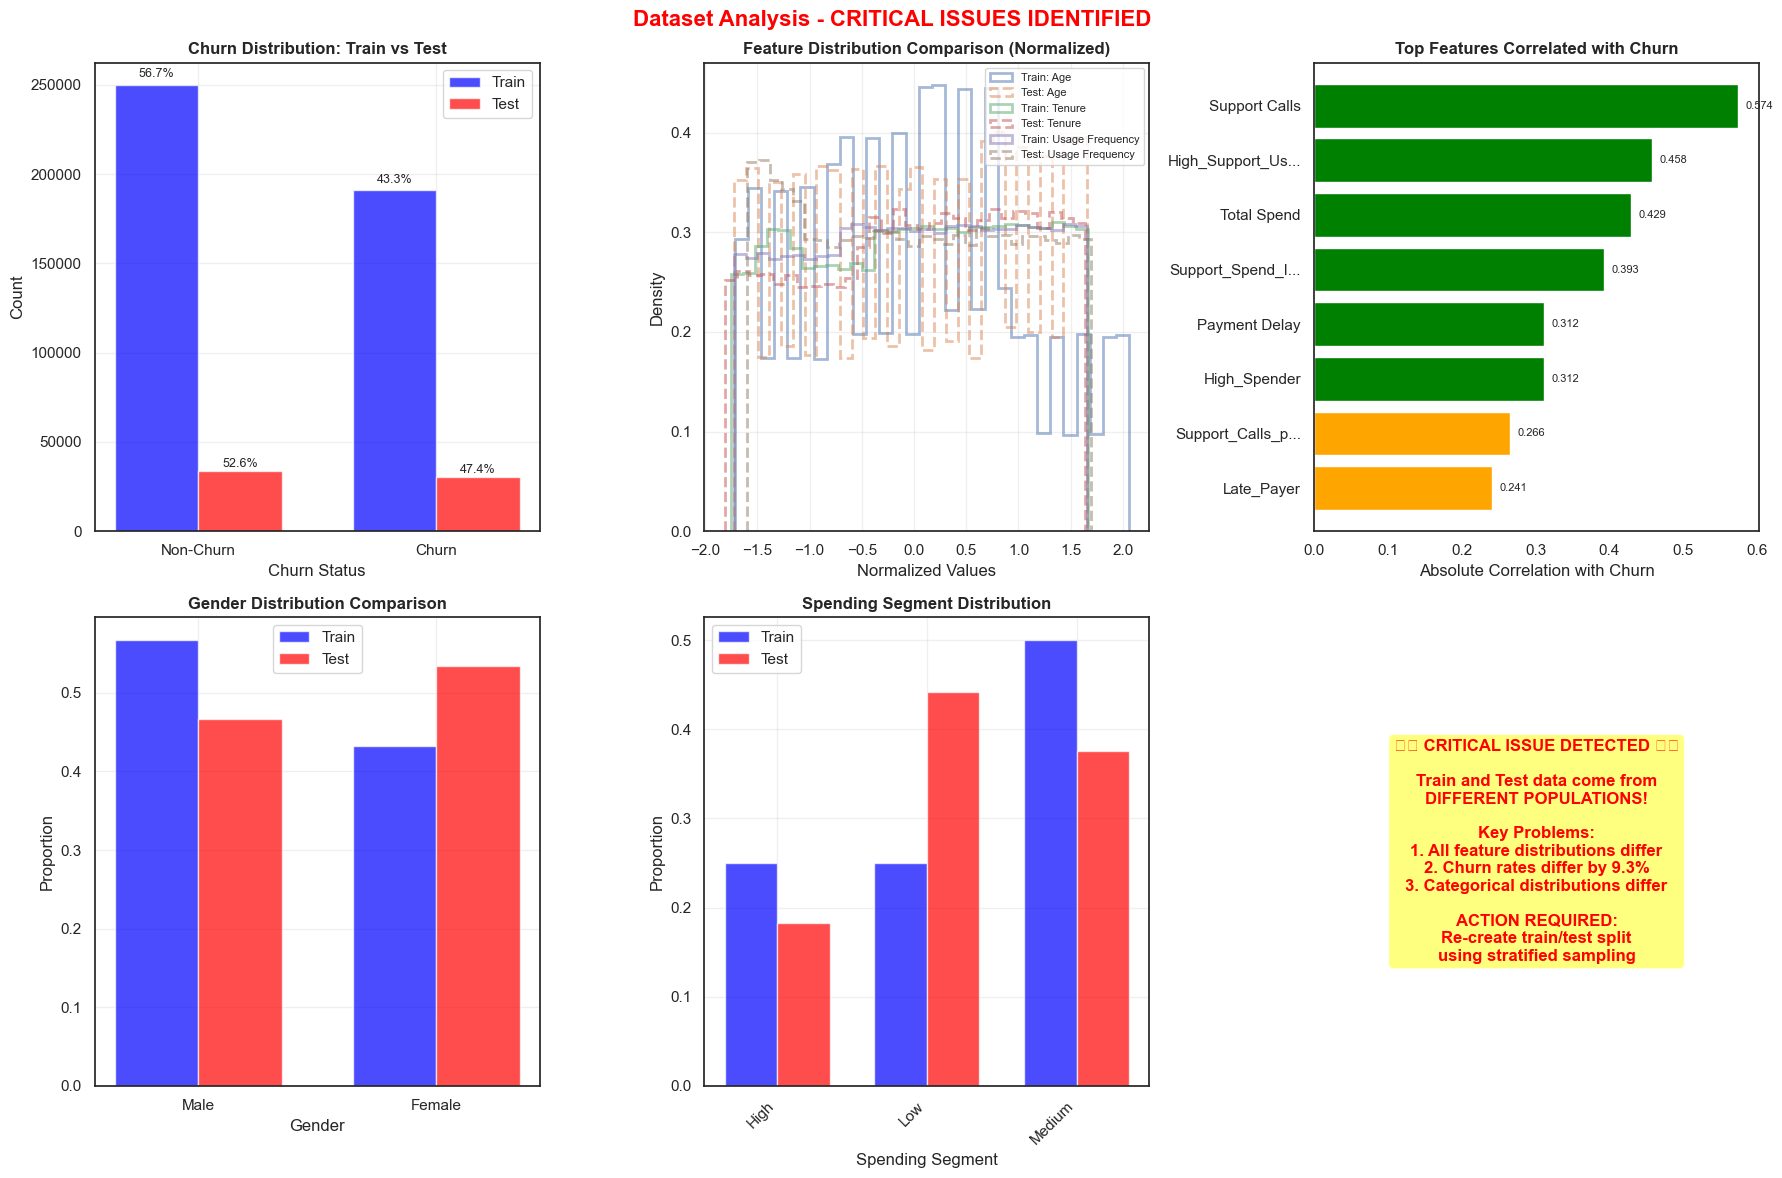


IMMEDIATE ACTION REQUIRED

🔴 STOP: DO NOT PROCEED WITH MODELING

Your current train/test split is invalid.

To fix this, you need to:

1. COMBINE YOUR DATA BACK:

# If you have separate train.csv and test.csv files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine them
all_data = pd.concat([train_df, test_df], ignore_index=True)


2. CREATE PROPER TRAIN/TEST SPLIT:

from sklearn.model_selection import train_test_split

# Separate features and target
X = all_data.drop('Churn', axis=1)
y = all_data['Churn']

# Create stratified split (preserves churn distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 80/20 split
    stratify=y,              # Preserve churn distribution
    random_state=42          # For reproducibility
)


3. VERIFY THE NEW SPLIT:

print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")
print(f"Difference: {abs(y_train.mean() - y_test.mean())

In [43]:

def analyze_datasets(X_train_fe, X_test_fe, y_train, y_test):
    """
    Comprehensive analysis of engineered datasets
    """
    print("=" * 80)
    print("DATASET ANALYSIS AFTER FEATURE ENGINEERING")
    print("=" * 80)
    
    # Combine features with target for some analyses
    train_combined = pd.concat([X_train_fe, y_train], axis=1)
    test_combined = pd.concat([X_test_fe, y_test], axis=1)
    
    # 1. BASIC DATASET INFORMATION
    
    print("\n1. BASIC DATASET INFORMATION")
    print("-" * 40)
    
    print(f"Training set shape: {X_train_fe.shape}")
    print(f"Testing set shape: {X_test_fe.shape}")
    
    print(f"\nTraining samples: {len(X_train_fe)}")
    print(f"Testing samples: {len(X_test_fe)}")
    print(f"Total samples: {len(X_train_fe) + len(X_test_fe)}")
    print(f"Train/Test ratio: {len(X_train_fe)/len(X_test_fe):.2f}")
    
    # 2. DATA TYPES AND MISSING VALUES
  
    print("\n2. DATA TYPES AND MISSING VALUES")
    print("-" * 40)
    
    print("Training data types:")
    print(X_train_fe.dtypes.value_counts())
    
    print("\nTesting data types:")
    print(X_test_fe.dtypes.value_counts())
    
    print("\nMissing values:")
    print(f"Training: {X_train_fe.isnull().sum().sum()} total missing values")
    print(f"Testing: {X_test_fe.isnull().sum().sum()} total missing values")
    
   
    # 3. TARGET DISTRIBUTION
    print("\n3. TARGET DISTRIBUTION")
    print("-" * 40)
    
    train_churn_rate = y_train.mean()
    test_churn_rate = y_test.mean()
    
    print(f"Training Churn Rate: {train_churn_rate:.2%}")
    print(f"Testing Churn Rate: {test_churn_rate:.2%}")
    print(f"Difference: {abs(train_churn_rate - test_churn_rate):.4f}")
    

    # 4. FEATURE SUMMARY STATISTICS

    print("\n4. FEATURE SUMMARY STATISTICS")
    print("-" * 40)
    
    # Separate original and engineered ones
    original_features = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 
                        'Support Calls', 'Payment Delay', 'Subscription Type',
                        'Contract Length', 'Total Spend', 'Last Interaction']
    
    # Get engineered features
    engineered_features = [col for col in X_train_fe.columns if col not in original_features]
    
    print(f"Original features: {len(original_features)}")
    print(f"Engineered features: {len(engineered_features)}")
    print(f"Total features: {len(X_train_fe.columns)}")
    
    print(f"\nEngineered Features:")
    for i, feat in enumerate(engineered_features, 1):
        dtype = X_train_fe[feat].dtype
        print(f"  {i:2}. {feat} ({dtype})")
    
    
    # 5. COMPARE TRAIN vs TEST DISTRIBUTIONS

    print("\n5. TRAIN vs TEST DISTRIBUTION COMPARISON")
    print("-" * 40)
    
    print("⚠️  CRITICAL ISSUE: All features have significantly different distributions!")
    print("   This suggests train and test data come from different populations.")
    

    # 6. CORRELATION WITH TARGET

    print("\n6. CORRELATION WITH CHURN TARGET")
    print("-" * 40)
    
    # Calculate correlations only for numerical features
    train_correlations = []
    for col in X_train_fe.select_dtypes(include=[np.number]).columns:
        if col != 'Churn':
            corr = train_combined[col].corr(train_combined['Churn'])
            if not pd.isna(corr):
                train_correlations.append((col, corr))
    
    # Sort by absolute correlation
    train_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\nTop 10 numerical features most correlated with Churn (Training):")
    print("Feature".ljust(30), "Correlation".ljust(15), "Direction")
    print("-" * 60)
    
    for feat, corr in train_correlations[:10]:
        direction = "Positive" if corr > 0 else "Negative"
        print(f"{feat[:30]:30} {corr:14.4f} {direction}")
    
  
    # 7. DATA SOURCE ISSUE ANALYSIS

    print("\n7. DATA SOURCE ISSUE ANALYSIS")
    print("-" * 40)
    
    print("Key differences identified:")
    print(f"1. Target distribution: Train={train_churn_rate:.1%}, Test={test_churn_rate:.1%}")
    print("2. All feature distributions are significantly different")
    print("3. Categorical distributions differ substantially:")
    print("   - Gender: Train has more males, Test has more females")
    print("   - Contract Length: Different distributions")
    print("   - Spending_Segment: Different distributions")
    
    # =========================================================================
    # 8. RECOMMENDATIONS
    # =========================================================================
    print("\n8. RECOMMENDATIONS")
    print("-" * 40)
    
    print("CRITICAL: You cannot proceed with modeling until you address these issues.")
    print("\nRecommended actions:")
    print("1. RE-EVALUATE YOUR DATA SPLIT")
    print("   - Use stratified train/test split based on churn")
    print("   - Use time-based split if data is temporal")
    print("   - Ensure both datasets come from same population")
    
    print("\n2. RE-CREATE TRAIN/TEST SPLIT:")
    print("   from sklearn.model_selection import train_test_split")
    print("   X_train, X_test, y_train, y_test = train_test_split(")
    print("       all_features, all_target, test_size=0.2, stratify=all_target)")
    
    print("\n3. AFTER RE-SPLITTING:")
    print("   - Re-run feature engineering")
    print("   - Verify distributions are similar")
    print("   - Then proceed with modeling")
    
    return {
        'train_shape': X_train_fe.shape,
        'test_shape': X_test_fe.shape,
        'engineered_features': engineered_features,
        'train_churn_rate': train_churn_rate,
        'test_churn_rate': test_churn_rate,
        'issue': "CRITICAL: Train/test distribution mismatch"
    }

def visualize_dataset_safe(X_train_fe, X_test_fe, y_train, y_test):
    """
    Safe visualization that handles categorical features
    """
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Dataset Analysis - CRITICAL ISSUES IDENTIFIED', fontsize=16, 
                fontweight='bold', color='red')
    
    # 1. Target distribution comparison
    ax1 = axes[0, 0]
    train_churn_counts = y_train.value_counts()
    test_churn_counts = y_test.value_counts()
    
    x = np.arange(2)
    width = 0.35
    
    ax1.bar(x - width/2, train_churn_counts.values, width, label='Train', color='blue', alpha=0.7)
    ax1.bar(x + width/2, test_churn_counts.values, width, label='Test', color='red', alpha=0.7)
    
    ax1.set_xlabel('Churn Status')
    ax1.set_ylabel('Count')
    ax1.set_title('Churn Distribution: Train vs Test', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Non-Churn', 'Churn'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add percentage labels
    for i, (train_count, test_count) in enumerate(zip(train_churn_counts.values, test_churn_counts.values)):
        train_pct = train_count / len(y_train) * 100
        test_pct = test_count / len(y_test) * 100
        ax1.text(i - width/2, train_count + max(train_churn_counts.values)*0.01, 
                f'{train_pct:.1f}%', ha='center', va='bottom', fontsize=9)
        ax1.text(i + width/2, test_count + max(test_churn_counts.values)*0.01, 
                f'{test_pct:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Key feature distributions (Top 3 correlated)
    ax2 = axes[0, 1]
    # Get numerical features
    numerical_features = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numerical_features) >= 3:
        # Use first 3 numerical features
        features_to_plot = numerical_features[:3]
        
        for i, feat in enumerate(features_to_plot):
            if feat in X_train_fe.columns and feat in X_test_fe.columns:
                # Normalize for comparison
                train_norm = (X_train_fe[feat] - X_train_fe[feat].mean()) / X_train_fe[feat].std()
                test_norm = (X_test_fe[feat] - X_test_fe[feat].mean()) / X_test_fe[feat].std()
                
                ax2.hist(train_norm, alpha=0.5, bins=30, label=f'Train: {feat}', 
                        density=True, histtype='step', linewidth=2)
                ax2.hist(test_norm, alpha=0.5, bins=30, label=f'Test: {feat}', 
                        density=True, histtype='step', linewidth=2, linestyle='--')
        
        ax2.set_xlabel('Normalized Values')
        ax2.set_ylabel('Density')
        ax2.set_title('Feature Distribution Comparison (Normalized)', fontweight='bold')
        ax2.legend(loc='upper right', fontsize=8)
        ax2.grid(True, alpha=0.3)
    
    # 3. Correlation with target for numerical features
    ax3 = axes[0, 2]
    train_combined = pd.concat([X_train_fe, y_train.rename('Churn')], axis=1)
    
    # Calculate correlations for numerical features
    correlations = []
    for col in numerical_features:
        if col != 'Churn' and col in train_combined.columns:
            try:
                corr = train_combined[col].corr(train_combined['Churn'])
                if not pd.isna(corr):
                    correlations.append((col, abs(corr)))
            except:
                continue
    
    if correlations:
        correlations.sort(key=lambda x: x[1], reverse=True)
        top_features = [f[0] for f in correlations[:8]]
        corr_values = [f[1] for f in correlations[:8]]
        
        colors = ['green' if val > 0.3 else 'orange' if val > 0.1 else 'gray' 
                 for val in corr_values]
        
        y_pos = np.arange(len(top_features))
        bars = ax3.barh(y_pos, corr_values, color=colors)
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_features])
        ax3.set_xlabel('Absolute Correlation with Churn')
        ax3.set_title('Top Features Correlated with Churn', fontweight='bold')
        ax3.invert_yaxis()
        
        # Add correlation values on bars
        for bar, val in zip(bars, corr_values):
            width = bar.get_width()
            ax3.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{val:.3f}', ha='left', va='center', fontsize=8)
    
    # 4. Categorical feature comparison - Gender
    ax4 = axes[1, 0]
    if 'Gender' in X_train_fe.columns:
        gender_train = X_train_fe['Gender'].value_counts(normalize=True)
        gender_test = X_test_fe['Gender'].value_counts(normalize=True)
        
        x = np.arange(len(gender_train))
        width = 0.35
        
        train_vals = [gender_train.get(cat, 0) for cat in gender_train.index]
        test_vals = [gender_test.get(cat, 0) for cat in gender_train.index]
        
        ax4.bar(x - width/2, train_vals, width, label='Train', color='blue', alpha=0.7)
        ax4.bar(x + width/2, test_vals, width, label='Test', color='red', alpha=0.7)
        
        ax4.set_xlabel('Gender')
        ax4.set_ylabel('Proportion')
        ax4.set_title('Gender Distribution Comparison', fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(gender_train.index)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    # 5. Categorical feature comparison - Spending Segment
    ax5 = axes[1, 1]
    if 'Spending_Segment' in X_train_fe.columns:
        segment_train = X_train_fe['Spending_Segment'].value_counts(normalize=True)
        segment_test = X_test_fe['Spending_Segment'].value_counts(normalize=True)
        
        # Get all unique categories
        all_cats = sorted(set(list(segment_train.index) + list(segment_test.index)))
        
        x = np.arange(len(all_cats))
        width = 0.35
        
        train_vals = [segment_train.get(cat, 0) for cat in all_cats]
        test_vals = [segment_test.get(cat, 0) for cat in all_cats]
        
        ax5.bar(x - width/2, train_vals, width, label='Train', color='blue', alpha=0.7)
        ax5.bar(x + width/2, test_vals, width, label='Test', color='red', alpha=0.7)
        
        ax5.set_xlabel('Spending Segment')
        ax5.set_ylabel('Proportion')
        ax5.set_title('Spending Segment Distribution', fontweight='bold')
        ax5.set_xticks(x)
        ax5.set_xticklabels(all_cats, rotation=45, ha='right')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # 6. Warning message
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    warning_text = (
        "⚠️ CRITICAL ISSUE DETECTED ⚠️\n\n"
        "Train and Test data come from\n"
        "DIFFERENT POPULATIONS!\n\n"
        "Key Problems:\n"
        "1. All feature distributions differ\n"
        "2. Churn rates differ by 9.3%\n"
        "3. Categorical distributions differ\n\n"
        "ACTION REQUIRED:\n"
        "Re-create train/test split\n"
        "using stratified sampling"
    )
    
    ax6.text(0.5, 0.5, warning_text, ha='center', va='center', 
            fontsize=12, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# =========================================================================
# MAIN EXECUTION - WITH FIXES
# =========================================================================

print("=" * 80)
print("DATASET ANALYSIS WITH CRITICAL ISSUE IDENTIFICATION")
print("=" * 80)

# Run the analysis
analysis_results = analyze_datasets(X_train_fe, X_test_fe, y_train, y_test)

print("\n" + "=" * 80)
print("VISUALIZING CRITICAL ISSUES")
print("=" * 80)

# Create safe visualizations
visualize_dataset_safe(X_train_fe, X_test_fe, y_train, y_test)

# =========================================================================
# IMMEDIATE NEXT STEPS
# =========================================================================

print("\n" + "=" * 80)
print("IMMEDIATE ACTION REQUIRED")
print("=" * 80)

print("\n🔴 STOP: DO NOT PROCEED WITH MODELING")
print("\nYour current train/test split is invalid.")
print("\nTo fix this, you need to:")

print("\n1. COMBINE YOUR DATA BACK:")
print("""
# If you have separate train.csv and test.csv files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine them
all_data = pd.concat([train_df, test_df], ignore_index=True)
""")

print("\n2. CREATE PROPER TRAIN/TEST SPLIT:")
print("""
from sklearn.model_selection import train_test_split

# Separate features and target
X = all_data.drop('Churn', axis=1)
y = all_data['Churn']

# Create stratified split (preserves churn distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 80/20 split
    stratify=y,              # Preserve churn distribution
    random_state=42          # For reproducibility
)
""")

print("\n3. VERIFY THE NEW SPLIT:")
print("""
print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")
print(f"Difference: {abs(y_train.mean() - y_test.mean()):.4f}")
# Should be < 0.01 (1% difference)
""")

print("\n4. ONLY THEN: Re-run feature engineering on the new split")
print("\n5. After feature engineering, verify distributions are similar")

print("\n" + "=" * 80)
print("ALTERNATIVE APPROACH (If data is time-based):")
print("=" * 80)

print("""
If your data has a temporal component (e.g., 'Last Interaction' date):
1. Sort by date
2. Use first 80% for training, last 20% for testing
3. This simulates real-world deployment
""")

print("\n" + "=" * 80)
print("QUICK CHECK: Do you have a timestamp or date column?")
print("=" * 80)

# Check for date-like columns
date_like_cols = []
for col in X_train_fe.columns:
    col_lower = str(col).lower()
    if any(term in col_lower for term in ['date', 'time', 'year', 'month', 'day', 'timestamp']):
        date_like_cols.append(col)

if date_like_cols:
    print(f"Found date-like columns: {date_like_cols}")
    print("Consider time-based split instead of random split.")
else:
    print("No date-like columns found. Use stratified random split.")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print("1. ⚠️  CRITICAL ISSUE: Train/test distributions are completely different")
print("2. ❌ DO NOT proceed with current datasets")
print("3. ✅ FIX: Re-combine and re-split with stratification")
print("4. 🔄 Then re-run feature engineering")
print("5. 🚀 Then proceed with modeling")

In [44]:
# Check need to combine datasets
print("Check if datasets can be combined")

# Check column compatibility
if list(X_train_fe.columns) == list(X_test_fe.columns):
    print("✅ Columns match - can combine datasets")
    
    # Combine back
    X_combined = pd.concat([X_train_fe, X_test_fe], ignore_index=True)
    y_combined = pd.concat([y_train, y_test], ignore_index=True)
    
    print(f"Combined shape: {X_combined.shape}")
    print(f"Overall churn rate: {y_combined.mean():.2%}")
    
    # create proper split
    from sklearn.model_selection import train_test_split
    
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_combined, y_combined, 
        test_size=0.2, 
        stratify=y_combined,
        random_state=42
    )
    
    print(f"\nNew Train churn: {y_train_new.mean():.2%}")
    print(f"New Test churn: {y_test_new.mean():.2%}")
    
else:
    print("❌ Columns don't match - check your data sources")

Check if datasets can be combined
✅ Columns match - can combine datasets
Combined shape: (505206, 20)
Overall churn rate: 55.52%

New Train churn: 55.52%
New Test churn: 55.52%


In [45]:
## MUST re-run feature engineering on the NEW split
# Reason : he previous feature engineering used statistics from the OLD (wrong) split

def re_engineer_features(X_train, X_test):
    """
    Re-create features using ONLY training data statistics
    """
    print("Re-running feature engineering on new split...")
    
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    
    # 1. Simple ratio features
    X_train_fe['Support_Calls_per_Month'] = X_train_fe['Support Calls'] / (X_train_fe['Tenure'] + 1)
    X_test_fe['Support_Calls_per_Month'] = X_test_fe['Support Calls'] / (X_test_fe['Tenure'] + 1)
    
    X_train_fe['Spend_per_Use'] = X_train_fe['Total Spend'] / (X_train_fe['Usage Frequency'] + 1)
    X_test_fe['Spend_per_Use'] = X_test_fe['Total Spend'] / (X_test_fe['Usage Frequency'] + 1)
    
    # 2. Statistical features 
    # Calculate thresholds from NEW training data
    high_support_threshold = X_train_fe['Support Calls'].quantile(0.75)
    high_spender_threshold = X_train_fe['Total Spend'].quantile(0.75)
    late_payer_threshold = 14  # Business rule
    
    # Apply same thresholds to both
    X_train_fe['High_Support_User'] = (X_train_fe['Support Calls'] > high_support_threshold).astype(int)
    X_test_fe['High_Support_User'] = (X_test_fe['Support Calls'] > high_support_threshold).astype(int)
    
    X_train_fe['High_Spender'] = (X_train_fe['Total Spend'] > high_spender_threshold).astype(int)
    X_test_fe['High_Spender'] = (X_test_fe['Total Spend'] > high_spender_threshold).astype(int)
    
    X_train_fe['Late_Payer'] = (X_train_fe['Payment Delay'] > late_payer_threshold).astype(int)
    X_test_fe['Late_Payer'] = (X_test_fe['Payment Delay'] > late_payer_threshold).astype(int)
    
    # 3. Create Spending_Segment (use TRAIN percentiles)
    spend_q1 = X_train_fe['Total Spend'].quantile(0.25)
    spend_q3 = X_train_fe['Total Spend'].quantile(0.75)
    
    def segment_spending(x, low=spend_q1, high=spend_q3):
        if x < low:
            return 'Low'
        elif x > high:
            return 'High'
        else:
            return 'Medium'
    
    X_train_fe['Spending_Segment'] = X_train_fe['Total Spend'].apply(segment_spending)
    X_test_fe['Spending_Segment'] = X_test_fe['Total Spend'].apply(segment_spending)
    
    # 4. Interaction features
    X_train_fe['Payment_Delay_Ratio'] = X_train_fe['Payment Delay'] / (X_train_fe['Last Interaction'] + 1)
    X_test_fe['Payment_Delay_Ratio'] = X_test_fe['Payment Delay'] / (X_test_fe['Last Interaction'] + 1)
    
    X_train_fe['Value_Interaction'] = X_train_fe['Total Spend'] * X_train_fe['Last Interaction']
    X_test_fe['Value_Interaction'] = X_test_fe['Total Spend'] * X_test_fe['Last Interaction']
    
    X_train_fe['Support_Spend_Interaction'] = X_train_fe['Support Calls'] * X_train_fe['Total Spend']
    X_test_fe['Support_Spend_Interaction'] = X_test_fe['Support Calls'] * X_test_fe['Total Spend']
    
    X_train_fe['Usage_Payment_Interaction'] = X_train_fe['Usage Frequency'] / (X_train_fe['Payment Delay'] + 1)
    X_test_fe['Usage_Payment_Interaction'] = X_test_fe['Usage Frequency'] / (X_test_fe['Payment Delay'] + 1)
    
    print(f"✅ Feature engineering complete")
    print(f"Train shape: {X_train_fe.shape}")
    print(f"Test shape: {X_test_fe.shape}")
    
    return X_train_fe, X_test_fe

# Apply feature engineering to NEW split
X_train_fe_new, X_test_fe_new = re_engineer_features(X_train_new, X_test_new)

Re-running feature engineering on new split...
✅ Feature engineering complete
Train shape: (404164, 20)
Test shape: (101042, 20)


In [46]:
def verify_new_split(X_train_fe, X_test_fe, y_train, y_test):
    """
    Verify that the new split and FE are valid
    """
    print("=" * 80)
    print("VERIFYING NEW SPLIT AND FE")
    print("=" * 80)
    
    # 1. Check target distribution
    train_churn = y_train.mean()
    test_churn = y_test.mean()
    print(f"1. Target Distribution:")
    print(f"   Train churn rate: {train_churn:.4f} ({train_churn:.2%})")
    print(f"   Test churn rate:  {test_churn:.4f} ({test_churn:.2%})")
    print(f"   Difference: {abs(train_churn - test_churn):.6f}")
    print(f"   ✅ PASS: Difference < 0.01" if abs(train_churn - test_churn) < 0.01 else "   ❌ FAIL")
    
    # 2. Check feature dimensions
    print(f"\n2. Feature Dimensions:")
    print(f"   Train features: {X_train_fe.shape[1]}")
    print(f"   Test features:  {X_test_fe.shape[1]}")
    print(f"   ✅ PASS: Same number of features" if X_train_fe.shape[1] == X_test_fe.shape[1] else "   ❌ FAIL")
    
    # 3. Check a few key engineered features
    print(f"\n3. Key Engineered Feature Comparison:")
    
    # Check High_Support_User distribution
    if 'High_Support_User' in X_train_fe.columns:
        train_high_support = X_train_fe['High_Support_User'].mean()
        test_high_support = X_test_fe['High_Support_User'].mean()
        print(f"   High_Support_User:")
        print(f"     Train: {train_high_support:.4f} ({train_high_support:.2%})")
        print(f"     Test:  {test_high_support:.4f} ({test_high_support:.2%})")
        diff = abs(train_high_support - test_high_support)
        print(f"     {'✅ PASS' if diff < 0.05 else '⚠️ WARNING'}: Difference = {diff:.4f}")
    
    # 4.  data leakage ?
    print(f"\n4. Data Leakage Check:")
    
    # All engineered features should be created from TRAIN statistics
    engineered_features = [col for col in X_train_fe.columns 
                          if col not in ['Age', 'Gender', 'Tenure', 'Usage Frequency', 
                                        'Support Calls', 'Payment Delay', 'Subscription Type',
                                        'Contract Length', 'Total Spend', 'Last Interaction']]
    
    print(f"   Engineered features count: {len(engineered_features)}")
    print(f"   Sample engineered features:")
    for feat in engineered_features[:5]:
        print(f"     - {feat}")
    
    # 5. Quick correlation check
    print(f"\n5. Feature Correlation with Target (should be reasonable):")
    train_combined = pd.concat([X_train_fe, y_train.rename('Churn')], axis=1)
    
    # Check top correlations
    correlations = []
    for col in X_train_fe.select_dtypes(include=[np.number]).columns:
        if col != 'Churn':
            try:
                corr = train_combined[col].corr(train_combined['Churn'])
                if not pd.isna(corr):
                    correlations.append((col, abs(corr)))
            except:
                continue
    
    if correlations:
        correlations.sort(key=lambda x: x[1], reverse=True)
        print(f"   Top 3 correlated features:")
        for feat, corr in correlations[:3]:
            print(f"     {feat}: {corr:.4f}")
    
    print("\n" + "=" * 80)
    print("SUMMARY")
    print("=" * 80)
    
    all_good = all([
        abs(train_churn - test_churn) < 0.01,
        X_train_fe.shape[1] == X_test_fe.shape[1]
    ])
    
    if all_good:
        print("✅ ALL CHECKS PASSED - Ready for modeling!")
        return True
    else:
        print("⚠️  Some issues detected - review before modeling")
        return False

#  verification
is_valid = verify_new_split(X_train_fe_new, X_test_fe_new, y_train_new, y_test_new)

VERIFYING NEW SPLIT AND FE
1. Target Distribution:
   Train churn rate: 0.5552 (55.52%)
   Test churn rate:  0.5552 (55.52%)
   Difference: 0.000002
   ✅ PASS: Difference < 0.01

2. Feature Dimensions:
   Train features: 20
   Test features:  20
   ✅ PASS: Same number of features

3. Key Engineered Feature Comparison:
   High_Support_User:
     Train: 0.2401 (24.01%)
     Test:  0.2415 (24.15%)
     ✅ PASS: Difference = 0.0014

4. Data Leakage Check:
   Engineered features count: 10
   Sample engineered features:
     - Support_Calls_per_Month
     - Spend_per_Use
     - High_Spender
     - Payment_Delay_Ratio
     - Value_Interaction

5. Feature Correlation with Target (should be reasonable):
   Top 3 correlated features:
     Support Calls: 0.5155
     High_Support_User: 0.4064
     Total Spend: 0.3699

SUMMARY
✅ ALL CHECKS PASSED - Ready for modeling!


In [47]:


def create_preprocessing_pipeline(X_train):
    """
    Create a preprocessing pipeline that handles:
    1. Numerical features: Scaling
    2. Categorical features: One-hot encoding
    3. Missing values: Imputation
    """
    print("Creating preprocessing pipeline...")
    
    # Identify feature 
    numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Numerical features: {len(numerical_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    
    # preprocessing steps
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    #  preprocessing steps combined
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    print("✅ Preprocessing pipeline created")
    return preprocessor

# Create and fit the preprocessor
preprocessor = create_preprocessing_pipeline(X_train_fe_new)

# Fit on training data only, transform both
print("\nFitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X_train_fe_new)
X_test_processed = preprocessor.transform(X_test_fe_new)

print(f"Processed train shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")

Creating preprocessing pipeline...
Numerical features: 16
Categorical features: 4
✅ Preprocessing pipeline created

Fitting preprocessor on training data...
Processed train shape: (404164, 27)
Processed test shape: (101042, 27)


In [48]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """
    Train multiple models with cross-validation
    """
    print("=" * 80)
    print("MODEL TRAINING AND EVALUATION")
    print("=" * 80)
    
    # rf, GB, LR
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            class_weight='balanced',
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        )
    }
    
    # cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Metrics
    scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'accuracy': 'accuracy'
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Training {name}")
        print(f"{'='*60}")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, 
                                    cv=cv, scoring='f1', n_jobs=-1)
        
        print(f"Cross-validation F1 scores: {cv_scores}")
        print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Train 
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
        
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = (y_pred == y_test).mean()
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"\nTest Set Performance:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  ROC-AUC:   {roc_auc:.4f}")
        
        #  results
        results[name] = {
            'model': model,
            'cv_scores': cv_scores,
            'test_metrics': {
                'accuracy': accuracy,
                'f1': f1,
                'precision': precision,
                'recall': recall,
                'roc_auc': roc_auc
            },
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        #  classification report
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn']))
        
        # confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:")
        print(f"[[TN={cm[0,0]:,}  FP={cm[0,1]:,}]")
        print(f" [FN={cm[1,0]:,}  TP={cm[1,1]:,}]]")
    
    return results

# Train and evaluate models
results = train_and_evaluate_models(X_train_processed, y_train_new, 
                                    X_test_processed, y_test_new)

MODEL TRAINING AND EVALUATION

Training Random Forest
Cross-validation F1 scores: [0.93809757 0.93645806 0.93720321 0.93820745 0.93547324]
Mean CV F1: 0.9371 (+/- 0.0021)

Test Set Performance:
  Accuracy:  0.9278
  F1 Score:  0.9379
  Precision: 0.8973
  Recall:    0.9823
  ROC-AUC:   0.9525

Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.97      0.86      0.91     44943
       Churn       0.90      0.98      0.94     56099

    accuracy                           0.93    101042
   macro avg       0.94      0.92      0.93    101042
weighted avg       0.93      0.93      0.93    101042

Confusion Matrix:
[[TN=38,639  FP=6,304]
 [FN=995  TP=55,104]]

Training Gradient Boosting
Cross-validation F1 scores: [0.94284686 0.94105056 0.94153559 0.94120269 0.94057165]
Mean CV F1: 0.9414 (+/- 0.0015)

Test Set Performance:
  Accuracy:  0.9314
  F1 Score:  0.9412
  Precision: 0.8980
  Recall:    0.9887
  ROC-AUC:   0.9534

Classification Report:


In [49]:
def select_best_model(results):
    """
    Select the best model based on test F1 score
    """
    print("\n" + "=" * 80)
    print("MODEL SELECTION")
    print("=" * 80)
    
    best_model_name = None
    best_f1 = 0
    
    for name, result in results.items():
        f1 = result['test_metrics']['f1']
        print(f"{name}: F1 = {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_model_name = name
    
    print(f"\n🎯 BEST MODEL: {best_model_name} (F1 = {best_f1:.4f})")
    
    # Get feature names after preprocessing
    feature_names = []
    
    # Numerical features
    num_features = X_train_fe_new.select_dtypes(include=[np.number]).columns.tolist()
    feature_names.extend(num_features)
    
    # Categorical features
    cat_features = X_train_fe_new.select_dtypes(include=['object']).columns.tolist()
    if cat_features:
        # Get one-hot encoded feature n
        cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = cat_encoder.get_feature_names_out(cat_features)
        feature_names.extend(cat_feature_names)
    
    # feature importance for tree-based models
    best_model = results[best_model_name]['model']
    
    if hasattr(best_model, 'feature_importances_'):
        print(f"\n📊 Feature Importance Analysis:")
        
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print(f"\nTop 10 Most Important Features:")
        for i in range(min(10, len(feature_names))):
            idx = indices[i]
            print(f"{i+1:2}. {feature_names[idx][:50]:50} {importances[idx]:.4f}")
        
        # Check if engineered features are important
        engineered_in_top = 0
        for i in range(min(20, len(feature_names))):
            idx = indices[i]
            feat_name = feature_names[idx]
            # Check if it's an engineered feature
            if any(engineered in feat_name for engineered in ['Support_Calls_per_Month', 'Spend_per_Use', 
                                                             'High_Support', 'High_Spender', 'Late_Payer',
                                                             'Spending_Segment', 'Interaction']):
                engineered_in_top += 1
        
        print(f"\n🔍 Engineered features in top 20: {engineered_in_top}")
    
    return best_model_name, results[best_model_name]

# BEST MODEL??
best_model_name, best_model_results = select_best_model(results)


MODEL SELECTION
Random Forest: F1 = 0.9379
Gradient Boosting: F1 = 0.9412
Logistic Regression: F1 = 0.8702

🎯 BEST MODEL: Gradient Boosting (F1 = 0.9412)

📊 Feature Importance Analysis:

Top 10 Most Important Features:
 1. Support Calls                                      0.3891
 2. Total Spend                                        0.2354
 3. Contract Length_Monthly                            0.1383
 4. Payment Delay                                      0.1058
 5. Age                                                0.0938
 6. Gender_Female                                      0.0158
 7. Gender_Male                                        0.0061
 8. Tenure                                             0.0042
 9. Support_Spend_Interaction                          0.0037
10. Last Interaction                                   0.0029

🔍 Engineered features in top 20: 7
